In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

data_URL = '/Users/kristivanmeter/Desktop/MIDS/Capstone/merged_faces.csv'
df = pd.read_csv(data_URL, encoding = "ISO-8859-1")
df.head()

,Unnamed: 0.1,Unnamed: 0,block_order,block_name,stimuli,valence,random_fixation,movement,accuracy,response_time,...,Avg Total RT Avoid Black,Avg Total RT Approach White,Avg Total RT Avoid White,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism,white_black,diversity_index
0,0,60,1,blkTestCatAAp,47,2,1900,Avoid,1,1384,...,1002.4,781.2,978.900000,3.75,4.75,2.75,4.00,1.50,14.813487,0.486712
1,40,160,1,blkTestCatAAp,32,1,1500,Approach,1,519,...,571.5,480.5,680.700000,4.50,3.75,2.50,3.50,1.50,60.740741,0.244615
2,80,260,1,blkTestCatAAp,43,2,1200,Avoid,1,828,...,657.1,718.0,648.800000,2.25,4.25,2.00,3.00,1.50,16.007435,0.461046
3,120,360,1,blkTestCatAAp,63,2,1500,Avoid,1,1224,...,1069.0,1107.9,1113.800000,5.00,3.50,3.75,4.75,1.75,133.571429,0.064736
4,160,460,1,blkTestCatAAp,51,2,800,Avoid,1,5188,...,1335.6,734.2,883.777778,3.00,5.00,2.50,4.00,2.75,0.187739,0.612749


In [17]:
list(df.columns)

['Unnamed: 0.1',
 'Unnamed: 0',
 'block_order',
 'block_name',
 'stimuli',
 'valence',
 'random_fixation',
 'movement',
 'accuracy',
 'response_time',
 'ImpVsExp',
 'participant',
 'Group',
 'Race',
 'Gender',
 'Duration (in seconds)',
 'ResponseId',
 'Age',
 'CurrentGender',
 'Sex',
 'RaceEthnicity',
 'Check1_1',
 'Political_1',
 'Zip',
 'Occupations',
 'PSYID',
 'FTBlack_1',
 'VCNegBlack_1',
 'VCPosBlack_1',
 'ECBlack_Neighbors',
 'ECBlack_WorkColleagues',
 'ECBlack_CloseFriends',
 'ECBlack_Married',
 'FTWhite_1',
 'VCNegWhite_1',
 'VCPosWhite_1',
 'ECWhite_Neighbors',
 'ECWhite_WorkColleagues',
 'ECWhite_CloseFriends',
 'ECWhite_Married',
 'MiniIPI_1_1',
 'MiniIPI_1_2',
 'MiniIPI_1_3',
 'MiniIPI_1_4',
 'MiniIPI_1_5',
 'MiniIPI_2_1',
 'MiniIPI_2_2',
 'MiniIPI_2_3',
 'MiniIPI_2_4',
 'MiniIPI_2_5',
 'MiniIPI_3_1',
 'MiniIPI_3_2',
 'MiniIPI_3_3',
 'MiniIPI_3_4',
 'MiniIPI_3_5',
 'MiniIPI_4_1',
 'MiniIPI_4_2',
 'MiniIPI_4_3',
 'MiniIPI_4_4',
 'MiniIPI_4_5',
 'Unclear',
 'Comments ',
 'ex

In [18]:
df.shape

(362, 89)

In [19]:
# List of desired columns
desired_columns = ['movement', 'response_time', 'ImpVsExp','accuracy',
                   'Age', 'CurrentGender', 'RaceEthnicity', 'Race', 'Political_1',
                    'stimuli', 'accuracy_total', 'white_black','diversity_index']

# Subset the DataFrame to include only the desired columns
df_filtered = df[desired_columns].copy()

print(df_filtered.dtypes)

movement            object
response_time        int64
ImpVsExp            object
accuracy             int64
Age                  int64
CurrentGender       object
RaceEthnicity       object
Race                object
Political_1         object
stimuli              int64
accuracy_total     float64
white_black        float64
diversity_index    float64
dtype: object


### Drop participants with accuracy < 0.7 and rt > 2500 or < 100

In [20]:
# Exclude outliers from rt
df_filtered = df_filtered.loc[df_filtered['response_time'] <= 2500, :]
df_filtered = df_filtered.loc[df_filtered['response_time'] >= 100, :]
df_filtered = df_filtered.loc[df_filtered['accuracy_total'] >= 0.70, :]
df_filtered = df_filtered.loc[df_filtered['accuracy']==1]

df_filtered.drop(columns=['accuracy_total', 'accuracy'], inplace=True)
print(df_filtered.shape)
df_filtered.head()

(334, 11)


,movement,response_time,ImpVsExp,Age,CurrentGender,RaceEthnicity,Race,Political_1,stimuli,white_black,diversity_index
0,Avoid,1384,Implicit,76,Female,"White alone, not Hispanic or Latino",Dr.Dre,Conservative,47,14.813487,0.486712
1,Approach,519,Implicit,77,Male,"White alone, not Hispanic or Latino",Dr.Dre,Conservative,32,60.740741,0.244615
2,Avoid,828,Implicit,59,Female,"White alone, not Hispanic or Latino",Dr.Dre,Strongly conservative,43,16.007435,0.461046
3,Avoid,1224,Implicit,64,Female,"White alone, not Hispanic or Latino",Dr.Dre,Moderate,63,133.571429,0.064736
5,Approach,686,Implicit,34,Female,Black or African American alone,Dr.Dre,Moderate,44,0.172270,0.406948


### Dropna

In [21]:
df_filtered.isna().sum()

movement           0
response_time      0
ImpVsExp           0
Age                0
CurrentGender      0
RaceEthnicity      0
Race               0
Political_1        0
stimuli            0
white_black        0
diversity_index    2
dtype: int64

In [22]:
df_filtered = df_filtered.dropna()
df_filtered.isna().sum()

movement           0
response_time      0
ImpVsExp           0
Age                0
CurrentGender      0
RaceEthnicity      0
Race               0
Political_1        0
stimuli            0
white_black        0
diversity_index    0
dtype: int64

In [23]:
print(df_filtered.shape)

(332, 11)


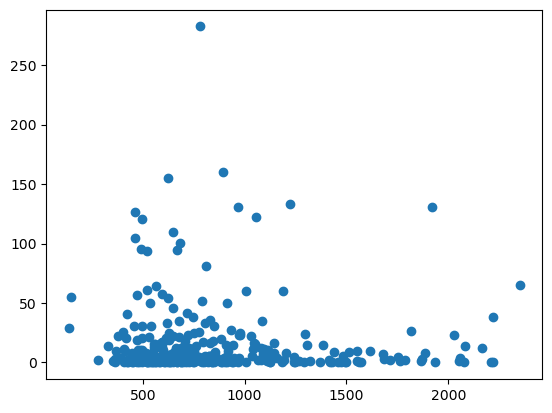

In [24]:
plt.scatter(df_filtered['response_time'], df_filtered['white_black'])

### Apply standard scaler to numerical columns

In [27]:
import numpy as np

# Step 1: Check unique values in the 'movement' column
unique_values = df_filtered['movement'].unique()
print(unique_values)

# Step 2: Replace non-numeric values with NaN
non_numeric_values = ['Avoid', 'Approach']  # Add any other non-numeric values if present
df_filtered['movement'] = df_filtered['movement'].replace(non_numeric_values, np.nan)

# Step 3: Fill NaN values with -1
df_filtered['movement'] = df_filtered['movement'].fillna(-1)

# Step 4: Convert the column to integers
df_filtered['movement'] = df_filtered['movement'].astype(int)





[-1 'Approach']


/var/folders/z2/38w7d0t53n9_7n4mywgz6phc0000gn/T/ipykernel_34403/1493066860.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered['movement'] = df_filtered['movement'].replace(non_numeric_values, np.nan)


In [28]:
df_filtered['movement'] = df_filtered['movement'].astype('int')
# Convert those columns to 'category' data type
categorical_columns = ['movement', 'ImpVsExp', 'CurrentGender', 'RaceEthnicity', 'Race']

for column in categorical_columns:
    df_filtered.loc[:, column] = df_filtered[column].astype('category')

print(df_filtered.dtypes)

movement             int64
response_time        int64
ImpVsExp            object
Age                  int64
CurrentGender       object
RaceEthnicity       object
Race                object
Political_1         object
stimuli              int64
white_black        float64
diversity_index    float64
dtype: object


In [29]:
# Drop original 'participant' and target 'response_time' for X
X = df_filtered.drop(columns=['response_time'])
y = df_filtered['response_time']

# Scale numeric features
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

X['rt'] = y
X.to_csv('names_cleaned_scaled.csv')